# Simulação e Otimização de Controle de Motor DC

Este notebook implementa a simulação de um motor DC e compara diferentes estratégias de controle (Lei de Controle Original vs PID).
Posteriormente, utilizam-se algoritmos de otimização (Busca Direta, Poliedro Flexível e Algoritmo Genético) para sintonizar os ganhos do PID automaticamente.

### Importação de Bibliotecas

In [136]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import time
import pandas as pd
import random
import importlib

import metrics
import fuzzy_logic
import optimizers
import controllers
import models

importlib.reload(metrics)
importlib.reload(fuzzy_logic)
importlib.reload(optimizers)
importlib.reload(controllers)
importlib.reload(models)

from metrics import calculate_indices
from fuzzy_logic import FuzzyTakagiSugeno, FuzzyMamdani
from optimizers import direct_search, flexible_polyhedron, genetic_algorithm
from controllers import PIDController
from models import system_model_original, system_model_pid, original_control_law

%matplotlib inline

### Definição de Parâmetros
* **tf**: Tempo final da simulação (segundos).
* **Motor (a, k)**: Parâmetros da função de transferência do motor.
* **Erros de Modelo**: Incertezas adicionadas para testar a robustez do controlador original.

In [137]:
tf = 6.0
ts_ms = 1.0

title = "motor_control_complete"

# Parâmetros do Motor
a = 1
k = 1
a_model_error = 0.1
k_model_error = 0.3

# Parâmetros Iniciais dos Controladores
k_c1 = 1  # Controlador Original
w_init = [10.0, 20.0, 0.1]  # PID Inicial [Kp, Ki, Kd]

# Configuração de Tempo e Referência
n = int((1 / (ts_ms / 1000.0)) * tf + 1)
time_vector = np.linspace(0, tf, n)
t_sim_step = time_vector[1] - time_vector[0]

# Sinais de Referência (Trajetória desejada)
torque_ref = np.sin(time_vector)
torquep_ref = np.cos(time_vector)

print("Configuração concluída.")
print(f"Motor: a={a}, k={k}")
print(f"PID Inicial: Kp={w_init[0]}, Ki={w_init[1]}, Kd={w_init[2]}")

Configuração concluída.
Motor: a=1, k=1
PID Inicial: Kp=10.0, Ki=20.0, Kd=0.1


### Modelagem e Técnicas Utilizadas

**1. Método de Euler:**
Utilizado para integração numérica rápida durante o loop de otimização (Algoritmo Genético, etc.). Como a otimização requer milhares de avaliações da função custo, o Euler (`x = x + dx * dt`) oferece velocidade. Para a validação final e gráficos, utiliza-se o `odeint` para maior precisão.

**2. Técnicas Fuzzy:**
*   **Takagi-Sugeno (Ordem Zero):** A técnica utilizada inicialmente. As saídas das regras são constantes (singletons) e a defuzzificação é feita por média ponderada. É computacionalmente eficiente.
*   **Mamdani:** Técnica clássica onde as saídas das regras são conjuntos fuzzy. A agregação é feita pelo máximo e a defuzzificação pelo centroide de área. É mais intuitiva mas computacionalmente mais pesada.

Neste projeto, compararemos ambas as técnicas.

In [138]:
# Simulação Controlador Original
states_orig = np.zeros((n - 1, 2))
states0 = [0, 0]
for i in range(n - 1):
    # Passando a, k, a_model_error, k_model_error explicitamente para garantir consistência
    out = odeint(
        system_model_original,
        states0,
        [0.0, t_sim_step],
        args=(torque_ref[i], torquep_ref[i], k_c1, a, k, a_model_error, k_model_error),
    )
    states0 = out[-1, :]
    states_orig[i] = states0

# Simulação Controlador PID Inicial
states_pid_init = np.zeros((n - 1, 2))
u_pid_init = np.zeros(n - 1)
states0 = [0, 0]
Kp, Ki, Kd = w_init

# Usando classe PIDController com Anti-Windup
pid_init = PIDController(Kp, Ki, Kd, limit=100.0, dt=t_sim_step)

for i in range(n - 1):
    ref = torque_ref[i]
    error = ref - states0[0]
    
    u = pid_init.update(error)
    u_pid_init[i] = u

    out = odeint(system_model_pid, states0, [0.0, t_sim_step], args=(u, a, k))
    states0 = out[-1, :]
    states_pid_init[i] = out[-1, :]

### Cálculo de Índices de Desempenho e Gráficos Iniciais
Calculamos MAE, MSE, ITAE e o índice Goodhart (ponderado) para avaliar numericamente os controladores.


Comparação de Desempenho:
Index           | Original     | PID Init    
---------------------------------------------
MAE             | 0.108590     | 0.041751    
MSE             | 0.016314     | 0.002189    
ITAE            | 2.130711     | 0.734998    
Goodhart        | 0.765660     | 0.264400    


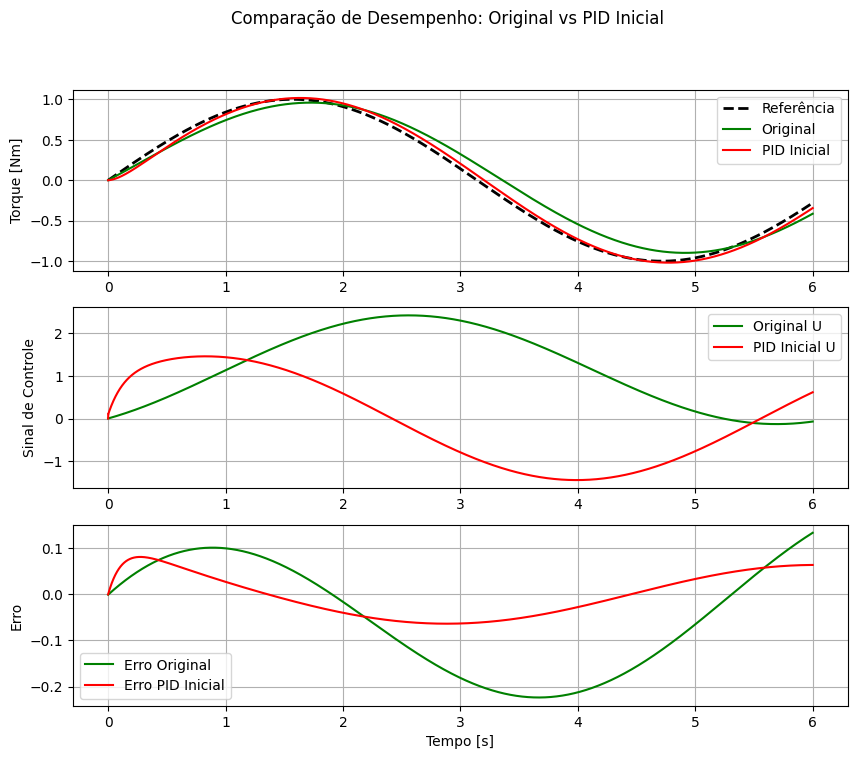

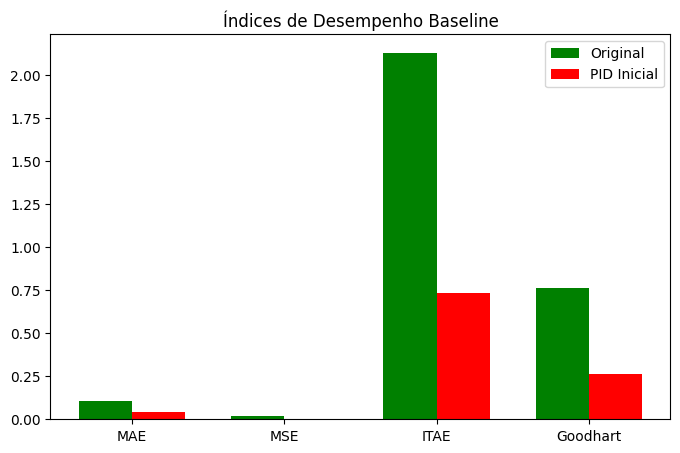

In [139]:
# Função de Cálculo de Índices
mae_orig, mse_orig, itae_orig, gh_orig = calculate_indices(
    torque_ref[:-1], states_orig[:, 0], time_vector[:-1], t_sim_step
)
mae_init, mse_init, itae_init, gh_init = calculate_indices(
    torque_ref[:-1], states_pid_init[:, 0], time_vector[:-1], t_sim_step
)

print("\nComparação de Desempenho:")
print(f"{'Index':<15} | {'Original':<12} | {'PID Init':<12}")
print("-" * 45)
print(f"{'MAE':<15} | {mae_orig:<12.6f} | {mae_init:<12.6f}")
print(f"{'MSE':<15} | {mse_orig:<12.6f} | {mse_init:<12.6f}")
print(f"{'ITAE':<15} | {itae_orig:<12.6f} | {itae_init:<12.6f}")
print(f"{'Goodhart':<15} | {gh_orig:<12.6f} | {gh_init:<12.6f}")

fig1 = plt.figure(figsize=(10, 8))
plt.suptitle("Comparação de Desempenho: Original vs PID Inicial")

plt.subplot(3, 1, 1)
plt.plot(time_vector[:-1], torque_ref[:-1], "k--", linewidth=2, label="Referência")
plt.plot(time_vector[:-1], states_orig[:, 0], "g", label="Original")
plt.plot(time_vector[:-1], states_pid_init[:, 0], "r", label="PID Inicial")
plt.ylabel("Torque [Nm]")
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(time_vector[:-1], states_orig[:, 1], "g", label="Original U")
plt.plot(time_vector[:-1], u_pid_init, "r", label="PID Inicial U")
plt.ylabel("Sinal de Controle")
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(time_vector[:-1], torque_ref[:-1] - states_orig[:, 0], "g", label="Erro Original")
plt.plot(time_vector[:-1], torque_ref[:-1] - states_pid_init[:, 0], "r", label="Erro PID Inicial")
plt.ylabel("Erro")
plt.xlabel("Tempo [s]")
plt.legend()
plt.grid(True)
plt.show()

fig2, ax = plt.subplots(figsize=(8, 5))
indices = ["MAE", "MSE", "ITAE", "Goodhart"]
x = np.arange(len(indices))
width = 0.35
ax.bar(x - width / 2, [mae_orig, mse_orig, itae_orig, gh_orig], width, label="Original", color="g")
ax.bar(x + width / 2, [mae_init, mse_init, itae_init, gh_init], width, label="PID Inicial", color="r")
ax.set_title("Índices de Desempenho Baseline")
ax.set_xticks(x)
ax.set_xticklabels(indices)
ax.legend()
plt.show()

## Algoritmos de Otimização
Definimos a Função Custo e os três algoritmos de busca.



### Otimização do Sistema PID
A função `run_simulation_cost` executa uma simulação rápida (Método de Euler) para calcular o erro de um conjunto de parâmetros.
**Melhorias implementadas:**
1.  **Saturação (`np.clip`)**: Limita a tensão `u` em +/- 100V para simular limites físicos e evitar valores infinitos.
2.  **Proteção de Estabilidade**: Aborta a simulação se o erro ou estado crescer demais (`1e9`).

In [140]:
def run_simulation_cost(w):
    Kp, Ki, Kd = w

    # Verificação básica de não negatividade
    if any(p < 0 for p in w):
        return 1e9

    # Limites de Saturação Física
    u_limit = 100.0

    x = 0
    cost_mae = 0
    cost_mse = 0
    cost_itae = 0
    
    # Instanciando o PID com Anti-Windup
    pid = PIDController(Kp, Ki, Kd, limit=u_limit, dt=t_sim_step)

    refs = torque_ref[:-1]

    for i in range(n - 1):
        ref = refs[i]
        error = ref - x
        
        # PID Update
        u = pid.update(error)

        # Dinâmica (Euler)
        dx = -a * k * x + k * u
        x = x + dx * t_sim_step

        # Checando estabilidade
        if abs(x) > 1e5:
            return 1e9

        abs_err = abs(error)
        cost_mae += abs_err

        # Proteção extra para o cálculo do quadrado
        try:
            cost_mse += error**2
        except RuntimeWarning:
            return 1e9

        cost_itae += time_vector[i] * abs_err

    MAE = cost_mae / (n - 1)
    MSE = cost_mse / (n - 1)
    ITAE = cost_itae * t_sim_step

    c1, c2, c3 = 0.33, 0.33, 0.34
    J = c1 * MAE + c2 * MSE + c3 * ITAE

    if np.isnan(J) or np.isinf(J):
        return 1e9

    return J

### Implementação dos Algoritmos
1.  **Direct Search**: Busca local iterativa em direções fixas.
2.  **Flexible Polyhedron (Nelder-Mead)**: Método geométrico baseado em simplex.
3.  **Genetic Algorithm**: Otimização estocástica baseada em evolução.

### Execução das Otimizações
Rodando os algoritmos definidos para encontrar os melhores valores de PID.

In [141]:
print("PARTE 2: Otimização")

print("Executando Busca Direta...")
t0 = time.time()
# Aumentando iterações para dar mais chance de convergência
w_ds, cost_ds = direct_search(run_simulation_cost, w_init, max_iter=50)
print(f"Concluído ({time.time()-t0:.2f}s). PID: {w_ds}, Custo: {cost_ds:.4f}")
print("Executando Poliedro Flexível...")
t0 = time.time()
w_fp, cost_fp = flexible_polyhedron(run_simulation_cost, w_init, max_iter=50)
print(f"Concluído ({time.time()-t0:.2f}s). PID: {w_fp}, Custo: {cost_fp:.4f}")

print("Executando Algoritmo Genético...")
t0 = time.time()
# Sementes para reprodutibilidade
random.seed(42)
np.random.seed(42)
# Definindo limites mais amplos para o PID [Kp, Ki, Kd]
pid_bounds = [(0, 300), (0, 300), (0, 20)]
w_ga, cost_ga = genetic_algorithm(run_simulation_cost, bounds=pid_bounds, pop_size=20, max_gen=20)
print(f"Concluído ({time.time()-t0:.2f}s). PID: {w_ga}, Custo: {cost_ga:.4f}")

# Escolhendo o melhor resultado automaticamente para o PID
results_pid = [
    (w_ds, cost_ds, "Busca Direta"),
    (w_fp, cost_fp, "Poliedro Flexível"),
    (w_ga, cost_ga, "Algoritmo Genético")
]
results_pid.sort(key=lambda x: x[1])

w_pid_opt = results_pid[0][0]
cost_pid_opt = results_pid[0][1]
best_method_pid = results_pid[0][2]

print(f"\nMelhor Método PID: {best_method_pid} com Custo {cost_pid_opt:.4f}")
print(f"Parâmetros Otimizados: {w_pid_opt}")

PARTE 2: Otimização
Executando Busca Direta...
Concluído (9.71s). PID: [5.20000000e+01 6.20000000e+01 2.32830699e-11], Custo: 0.0691
Executando Poliedro Flexível...
Concluído (7.59s). PID: [4.13577988e+01 8.78860603e+01 7.06717918e-04], Custo: 0.0613
Executando Algoritmo Genético...
Concluído (8.65s). PID: [175.12287934 222.20340192   0.        ], Custo: 0.0199

Melhor Método PID: Algoritmo Genético com Custo 0.0199
Parâmetros Otimizados: [175.12287934 222.20340192   0.        ]


### Resultados Finais e Comparação
Validação dos parâmetros otimizados rodando a simulação completa (com integrador preciso odeint) e gerando gráficos comparativos.

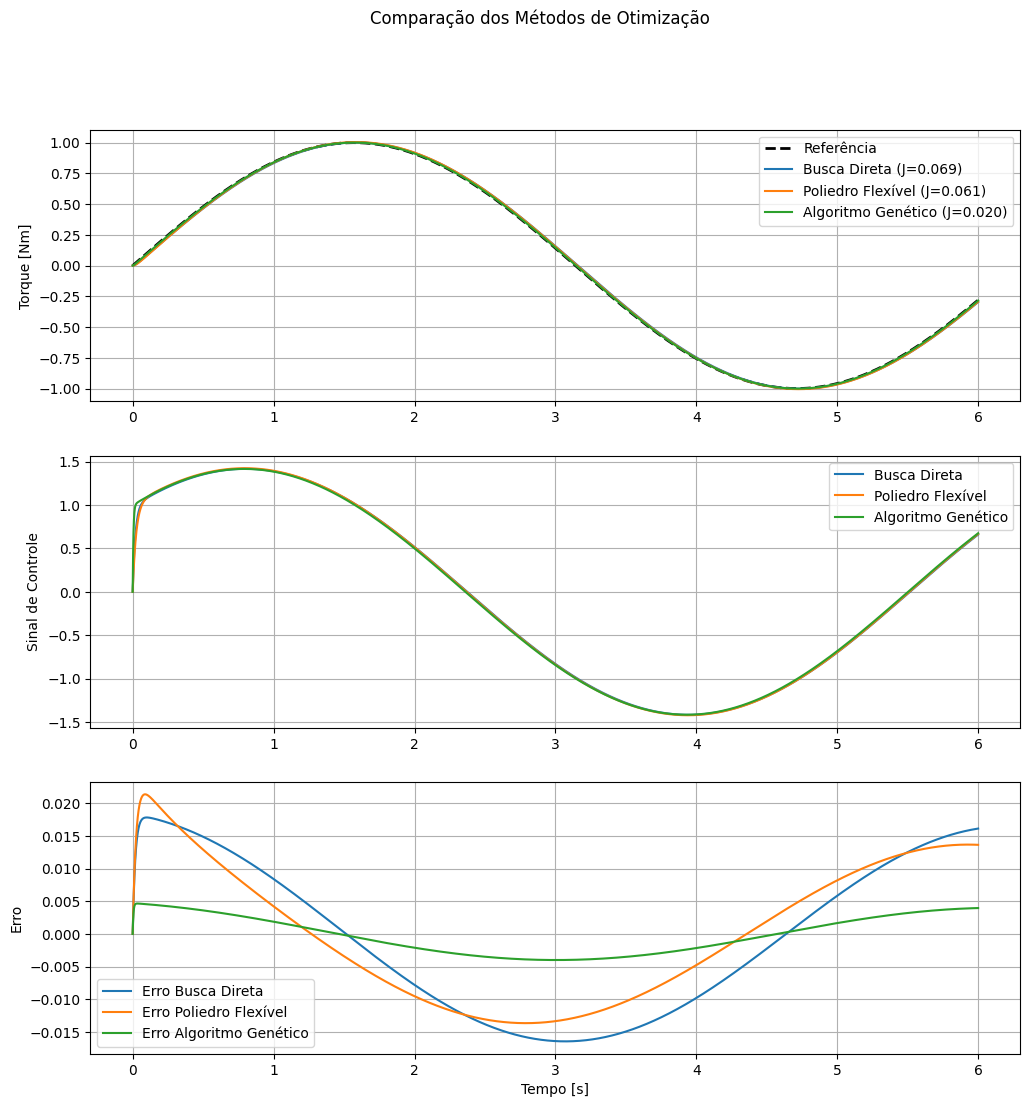

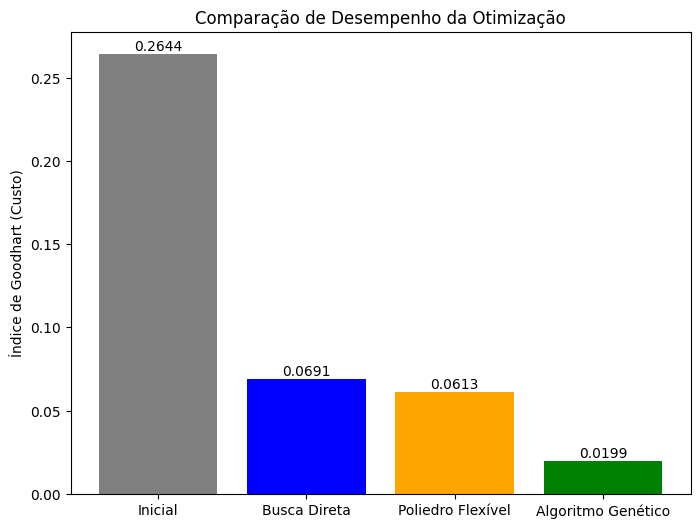

In [142]:
def run_full_sim(w):
    Kp, Ki, Kd = w
    states0 = [0, 0]
    states_out = np.zeros((n - 1, 2))
    u_out = np.zeros(n - 1)
    
    # Usando PIDController com Anti-Windup
    pid = PIDController(Kp, Ki, Kd, limit=100.0, dt=t_sim_step)
    
    for i in range(n - 1):
        ref = torque_ref[i]
        error = ref - states0[0]
        
        u = pid.update(error)
        u_out[i] = u
        
        out = odeint(system_model_pid, states0, [0.0, t_sim_step], args=(u, a, k))
        states0 = out[-1, :]
        states_out[i] = states0
    return states_out, u_out


states_ds, u_ds = run_full_sim(w_ds)
states_fp, u_fp = run_full_sim(w_fp)
states_ga, u_ga = run_full_sim(w_ga)

fig3, axs = plt.subplots(3, 1, figsize=(12, 12))
plt.suptitle("Comparação dos Métodos de Otimização")

axs[0].plot(time_vector[:-1], torque_ref[:-1], "k--", linewidth=2, label="Referência")
axs[0].plot(time_vector[:-1], states_ds[:, 0], label=f"Busca Direta (J={cost_ds:.3f})")
axs[0].plot(time_vector[:-1], states_fp[:, 0], label=f"Poliedro Flexível (J={cost_fp:.3f})")
axs[0].plot(time_vector[:-1], states_ga[:, 0], label=f"Algoritmo Genético (J={cost_ga:.3f})")
axs[0].set_ylabel("Torque [Nm]")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(time_vector[:-1], u_ds, label="Busca Direta")
axs[1].plot(time_vector[:-1], u_fp, label="Poliedro Flexível")
axs[1].plot(time_vector[:-1], u_ga, label="Algoritmo Genético")
axs[1].set_ylabel("Sinal de Controle")
axs[1].legend()
axs[1].grid(True)

axs[2].plot(time_vector[:-1], torque_ref[:-1] - states_ds[:, 0], label="Erro Busca Direta")
axs[2].plot(time_vector[:-1], torque_ref[:-1] - states_fp[:, 0], label="Erro Poliedro Flexível")
axs[2].plot(time_vector[:-1], torque_ref[:-1] - states_ga[:, 0], label="Erro Algoritmo Genético")
axs[2].set_ylabel("Erro")
axs[2].set_xlabel("Tempo [s]")
axs[2].legend()
axs[2].grid(True)
plt.show()

fig4 = plt.figure(figsize=(8, 6))
methods = ["Inicial", "Busca Direta", "Poliedro Flexível", "Algoritmo Genético"]
costs = [gh_init, cost_ds, cost_fp, cost_ga]
bars = plt.bar(methods, costs, color=["gray", "blue", "orange", "green"])
plt.ylabel("Índice de Goodhart (Custo)")
plt.title("Comparação de Desempenho da Otimização")
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        yval,
        f"{yval:.4f}",
        va="bottom",
        ha="center",
    )
plt.show()

# Implementação e Otimização do Controle Fuzzy

Nesta seção, introduzimos uma abordagem de **Controle Inteligente**. Diferente do PID, que usa equações fixas, o Controlador Fuzzy utiliza lógica nebulosa para tomar decisões baseadas em regras linguísticas (ex: "Se o erro é grande, aplique tensão alta").

**Objetivos:**
1.  Implementar as classes `FuzzyTakagiSugeno` e `FuzzyMamdani`.
2.  Utilizar o Algoritmo Genético (e outros métodos) para encontrar os melhores "Universos de Discurso" (parâmetros de calibração do Fuzzy).
3.  Comparar o Fuzzy Otimizado (ambos os métodos) contra o PID Otimizado.

### Definição e Simulação Baseline

In [ ]:
print("Fuzzy Baseline Simulations (Takagi-Sugeno & Mamdani)")

w_fuzzy_init = [1.0, 10.0, 50.0] 

print(f"Parâmetros Iniciais: Erro={w_fuzzy_init[0]}, Derivada={w_fuzzy_init[1]}, Saída={w_fuzzy_init[2]}")

# Takagi-Sugeno Baseline
print("Simulando Takagi-Sugeno")
fuzzy_ts_init = FuzzyTakagiSugeno(w_fuzzy_init)
states_ts_init = np.zeros((n - 1, 2))
u_ts_init = np.zeros(n - 1)

x = 0
prev_error = 0

for i in range(n - 1):
    ref = torque_ref[i]
    error = ref - x
    
    if i == 0: derr = 0
    else: derr = (error - prev_error) / t_sim_step
        
    u = fuzzy_ts_init.calcular(error, derr)
    u = np.clip(u, -100, 100)
    u_ts_init[i] = u
    
    out = odeint(system_model_pid, [x, 0], [0.0, t_sim_step], args=(u,))
    x = out[-1, 0]
    
    states_ts_init[i, 0] = x
    prev_error = error

# Mamdani Baseline
print("Simulando Mamdani")
fuzzy_mam_init = FuzzyMamdani(w_fuzzy_init)
states_mam_init = np.zeros((n - 1, 2))
u_mam_init = np.zeros(n - 1)

x = 0
prev_error = 0

for i in range(n - 1):
    ref = torque_ref[i]
    error = ref - x
    
    if i == 0: derr = 0
    else: derr = (error - prev_error) / t_sim_step
        
    u = fuzzy_mam_init.calcular(error, derr)
    u = np.clip(u, -100, 100)
    u_mam_init[i] = u
    
    out = odeint(system_model_pid, [x, 0], [0.0, t_sim_step], args=(u,))
    x = out[-1, 0]
    
    states_mam_init[i, 0] = x
    prev_error = error

# Para compatibilidade com células seguintes que esperam 'states_fuzzy_init'
states_fuzzy_init = states_ts_init
u_fuzzy_init = u_ts_init

--- PART 3: Fuzzy Baseline Simulations (Takagi-Sugeno & Mamdani) ---
Parâmetros Iniciais: Erro=1.0, Derivada=10.0, Saída=50.0
Simulando Takagi-Sugeno...
Simulando Mamdani...


### Cálculo de Índices e Gráficos Comparativos


                          TABELA: COMPARAÇÃO BASELINE                           
MÉTODO               | MAE        | MSE        | ITAE       | GOODHART  
--------------------------------------------------------------------------------
Original (Init)      | 0.1085     | 0.0163     | 2.1286     | 0.7649
PID (Init)           | 0.0418     | 0.0022     | 0.7350     | 0.2644
Fuzzy T-S (Init)     | 0.0303     | 0.0012     | 0.4900     | 0.1770
Fuzzy Mam (Init)     | 0.0247     | 0.0007     | 0.4032     | 0.1455



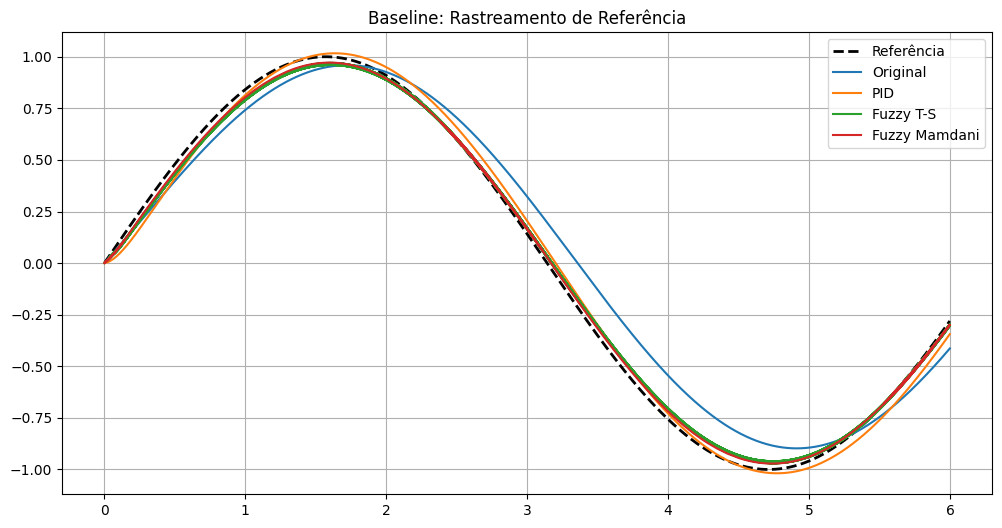

In [ ]:
# Recalculando baselines para garantir consistência (Euler para todos)

# Original
states_orig_init_arr = np.zeros(n - 1)
u_orig_init_arr = np.zeros(n - 1)
x_orig = 0
for i in range(n - 1):
    ref = torque_ref[i]
    dref = torquep_ref[i]
    u = original_control_law(x_orig, ref, dref, k_c1, a, k, a_model_error, k_model_error)
    u = np.clip(u, -100, 100)
    u_orig_init_arr[i] = u
    dx = -a * k * x_orig + k * u
    x_orig = x_orig + dx * t_sim_step
    states_orig_init_arr[i] = x_orig

# PID
states_pid_init_arr, u_pid_init_arr = run_full_sim(w_init)

# Fuzzy Takagi-Sugeno
fuzzy_ts_init = FuzzyTakagiSugeno(w_fuzzy_init)
states_fz_ts_init_arr = np.zeros(n - 1)
x = 0
prev_error = 0
for i in range(n - 1):
    ref = torque_ref[i]
    error = ref - x
    derr = (error - prev_error) / t_sim_step if i > 0 else 0
    u = fuzzy_ts_init.calcular(error, derr)
    u = np.clip(u, -100, 100)
    dx = -a * k * x + k * u
    x = x + dx * t_sim_step
    states_fz_ts_init_arr[i] = x
    prev_error = error

# Fuzzy Mamdani
fuzzy_mam_init = FuzzyMamdani(w_fuzzy_init)
states_fz_mam_init_arr = np.zeros(n - 1)
x = 0
prev_error = 0
for i in range(n - 1):
    ref = torque_ref[i]
    error = ref - x
    derr = (error - prev_error) / t_sim_step if i > 0 else 0
    u = fuzzy_mam_init.calcular(error, derr)
    u = np.clip(u, -100, 100)
    dx = -a * k * x + k * u
    x = x + dx * t_sim_step
    states_fz_mam_init_arr[i] = x
    prev_error = error

# Índices
idx_orig_base = calculate_indices(torque_ref[:-1], states_orig_init_arr, time_vector[:-1], t_sim_step)
idx_pid_base = calculate_indices(torque_ref[:-1], states_pid_init_arr[:, 0], time_vector[:-1], t_sim_step)
idx_fz_ts = calculate_indices(torque_ref[:-1], states_fz_ts_init_arr, time_vector[:-1], t_sim_step)
idx_fz_mam = calculate_indices(torque_ref[:-1], states_fz_mam_init_arr, time_vector[:-1], t_sim_step)

print("\n" + "="*80)
print(f"{'TABELA: COMPARAÇÃO BASELINE':^80}")
print("="*80)
print(f"{'MÉTODO':<20} | {'MAE':<10} | {'MSE':<10} | {'ITAE':<10} | {'GOODHART':<10}")
print("-" * 80)
print(f"{'Original (Init)':<20} | {idx_orig_base[0]:.4f}     | {idx_orig_base[1]:.4f}     | {idx_orig_base[2]:.4f}     | {idx_orig_base[3]:.4f}")
print(f"{'PID (Init)':<20} | {idx_pid_base[0]:.4f}     | {idx_pid_base[1]:.4f}     | {idx_pid_base[2]:.4f}     | {idx_pid_base[3]:.4f}")
print(f"{'Fuzzy T-S (Init)':<20} | {idx_fz_ts[0]:.4f}     | {idx_fz_ts[1]:.4f}     | {idx_fz_ts[2]:.4f}     | {idx_fz_ts[3]:.4f}")
print(f"{'Fuzzy Mam (Init)':<20} | {idx_fz_mam[0]:.4f}     | {idx_fz_mam[1]:.4f}     | {idx_fz_mam[2]:.4f}     | {idx_fz_mam[3]:.4f}")
print("="*80 + "\n")

plt.figure(figsize=(12, 6))
plt.title("Baseline: Rastreamento de Referência")
plt.plot(time_vector[:-1], torque_ref[:-1], "k--", linewidth=2, label="Referência")
plt.plot(time_vector[:-1], states_orig_init_arr, label="Original")
plt.plot(time_vector[:-1], states_pid_init_arr[:, 0], label="PID")
plt.plot(time_vector[:-1], states_fz_ts_init_arr, label="Fuzzy T-S")
plt.plot(time_vector[:-1], states_fz_mam_init_arr, label="Fuzzy Mamdani")
plt.legend()
plt.grid(True)
plt.show()

### Otimização do Fuzzy

In [ ]:
def run_fuzzy_cost(w):
    if any(p <= 1e-3 for p in w):
        return 1e9
    
    # Usando Takagi-Sugeno para otimização (mais rápido)
    fuzzy = FuzzyTakagiSugeno(w)
    
    x = 0
    cost_mae = 0
    cost_mse = 0
    cost_itae = 0
    prev_error = 0
    u_limit = 100.0
    
    refs = torque_ref[:-1]
    for i in range(n - 1):
        ref = refs[i]
        error = ref - x
        
        derr = (error - prev_error) / t_sim_step if i > 0 else 0
        
        u = fuzzy.calcular(error, derr)
        u = np.clip(u, -u_limit, u_limit)
        
        dx = -a * k * x + k * u
        x = x + dx * t_sim_step
        
        abs_err = abs(error)
        cost_mae += abs_err
        cost_mse += error**2
        cost_itae += time_vector[i] * abs_err
        prev_error = error
        
        if abs(x) > 1e5: return 1e9

    MAE = cost_mae / (n - 1)
    MSE = cost_mse / (n - 1)
    ITAE = cost_itae * t_sim_step

    c1, c2, c3 = 0.33, 0.33, 0.34
    return c1 * MAE + c2 * MSE + c3 * ITAE

print("\nINICIANDO OTIMIZAÇÃO DO FUZZY TAKAGI-SUGENO (3 MÉTODOS)")

w_fuzzy_init = [1.0, 10.0, 50.0] 

print("1. Rodando Busca Direta (Direct Search)")
t0 = time.time()
w_ds_fz, cost_ds_fz = direct_search(run_fuzzy_cost, w_fuzzy_init, max_iter=20)
print(f"   -> Done ({time.time()-t0:.2f}s). Params: {np.round(w_ds_fz, 2)}, Cost: {cost_ds_fz:.4f}")

print("2. Rodando Poliedro Flexível (Nelder-Mead)")
t0 = time.time()
w_fp_fz, cost_fp_fz = flexible_polyhedron(run_fuzzy_cost, w_fuzzy_init, max_iter=20)
print(f"   -> Done ({time.time()-t0:.2f}s). Params: {np.round(w_fp_fz, 2)}, Cost: {cost_fp_fz:.4f}")

print("3. Rodando Algoritmo Genético")
t0 = time.time()
random.seed(42)
np.random.seed(42)
fuzzy_bounds = [(0.1, 5.0), (0.1, 50.0), (10.0, 200.0)]
w_ga_fz, cost_ga_fz = genetic_algorithm(run_fuzzy_cost, pop_size=20, max_gen=15, bounds=fuzzy_bounds)
print(f"   -> Done ({time.time()-t0:.2f}s). Params: {np.round(w_ga_fz, 2)}, Cost: {cost_ga_fz:.4f}")

results_fz = [
    (w_ds_fz, cost_ds_fz, "Direct Search"),
    (w_fp_fz, cost_fp_fz, "Flex Poly"),
    (w_ga_fz, cost_ga_fz, "Genetic Alg")
]
results_fz.sort(key=lambda x: x[1])

w_fuzzy_opt = results_fz[0][0]
cost_fuzzy_opt = results_fz[0][1]
best_method_fz = results_fz[0][2]

print(f"\n>>> Melhor Método Fuzzy T-S: {best_method_fz} com Custo {cost_fuzzy_opt:.4f}")
print(f">>> Parâmetros Otimizados: {np.round(w_fuzzy_opt, 2)}")


--- INICIANDO OTIMIZAÇÃO DO FUZZY TAKAGI-SUGENO (3 MÉTODOS) ---
1. Rodando Busca Direta (Direct Search)...
   -> Done (25.69s). Params: [ 0.18 13.12 51.72], Cost: 0.0154
2. Rodando Poliedro Flexível (Nelder-Mead)...
   -> Done (17.44s). Params: [ 0.14 13.44 51.38], Cost: 0.0182
3. Rodando Algoritmo Genético...
   -> Done (35.00s). Params: [  0.23  43.83 127.42], Cost: 0.0068

>>> Melhor Método Fuzzy T-S: Genetic Alg com Custo 0.0068
>>> Parâmetros Otimizados: [  0.23  43.83 127.42]


In [ ]:
def run_fuzzy_mamdani_cost(w):
    if any(p <= 1e-3 for p in w):
        return 1e9
    
    # Mamdani é mais lento, então usamos menos iterações ou bounds mais restritos se necessário
    fuzzy = FuzzyMamdani(w)
    
    x = 0
    cost_mae = 0
    cost_mse = 0
    cost_itae = 0
    prev_error = 0
    u_limit = 100.0
    
    # Reduzindo pontos para otimização do Mamdani se for muito lento
    # Aqui usamos o vetor completo, mas em casos reais poderíamos fazer subsampling
    refs = torque_ref[:-1]
    
    for i in range(n - 1):
        ref = refs[i]
        error = ref - x
        
        derr = (error - prev_error) / t_sim_step if i > 0 else 0
        
        u = fuzzy.calcular(error, derr)
        u = np.clip(u, -u_limit, u_limit)
        
        dx = -a * k * x + k * u
        x = x + dx * t_sim_step
        
        abs_err = abs(error)
        cost_mae += abs_err
        cost_mse += error**2
        cost_itae += time_vector[i] * abs_err
        prev_error = error
        
        if abs(x) > 1e5: return 1e9

    MAE = cost_mae / (n - 1)
    MSE = cost_mse / (n - 1)
    ITAE = cost_itae * t_sim_step

    c1, c2, c3 = 0.33, 0.33, 0.34
    return c1 * MAE + c2 * MSE + c3 * ITAE

print("\nINICIANDO OTIMIZAÇÃO DO FUZZY MAMDANI (3 MÉTODOS)")
print("O método Mamdani é computacionalmente mais custoso.")
print("Executando com número reduzido de iterações para demonstração.")

w_mamdani_init = [1.0, 10.0, 50.0] 

print("1. Rodando Busca Direta (Mamdani)")
t0 = time.time()
w_ds_mam, cost_ds_mam = direct_search(run_fuzzy_mamdani_cost, w_mamdani_init, max_iter=5)
print(f"   -> Done ({time.time()-t0:.2f}s). Params: {np.round(w_ds_mam, 2)}, Cost: {cost_ds_mam:.4f}")

print("2. Rodando Poliedro Flexível (Mamdani)")
t0 = time.time()
w_fp_mam, cost_fp_mam = flexible_polyhedron(run_fuzzy_mamdani_cost, w_mamdani_init, max_iter=5)
print(f"   -> Done ({time.time()-t0:.2f}s). Params: {np.round(w_fp_mam, 2)}, Cost: {cost_fp_mam:.4f}")

print("3. Rodando Algoritmo Genético (Mamdani)")
t0 = time.time()
# População menor e menos gerações para Mamdani
w_ga_mam, cost_ga_mam = genetic_algorithm(run_fuzzy_mamdani_cost, pop_size=10, max_gen=5, bounds=fuzzy_bounds)
print(f"   -> Done ({time.time()-t0:.2f}s). Params: {np.round(w_ga_mam, 2)}, Cost: {cost_ga_mam:.4f}")

results_mam = [
    (w_ds_mam, cost_ds_mam, "Direct Search"),
    (w_fp_mam, cost_fp_mam, "Flex Poly"),
    (w_ga_mam, cost_ga_mam, "Genetic Alg")
]
results_mam.sort(key=lambda x: x[1])

w_mamdani_opt = results_mam[0][0]
cost_mamdani_opt = results_mam[0][1]
best_method_mam = results_mam[0][2]

print(f"\n>>> Melhor Método Fuzzy Mamdani: {best_method_mam} com Custo {cost_mamdani_opt:.4f}")
print(f">>> Parâmetros Otimizados Mamdani: {np.round(w_mamdani_opt, 2)}")


--- INICIANDO OTIMIZAÇÃO DO FUZZY MAMDANI (3 MÉTODOS) ---
Nota: O método Mamdani é computacionalmente mais custoso.
Executando com número reduzido de iterações para demonstração.
1. Rodando Busca Direta (Mamdani)...
   -> Done (36.35s). Params: [ 0.12 13.5  51.5 ], Cost: 0.0176
2. Rodando Poliedro Flexível (Mamdani)...
   -> Done (27.77s). Params: [ 0.22 10.56 50.17], Cost: 0.0343
3. Rodando Algoritmo Genético (Mamdani)...
   -> Done (41.20s). Params: [ 0.36 32.09 95.6 ], Cost: 0.0269

>>> Melhor Método Fuzzy Mamdani: Direct Search com Custo 0.0176
>>> Parâmetros Otimizados Mamdani: [ 0.12 13.5  51.5 ]


### Comparação dos Algoritmos de Otimização


MÉTODO               | MAE        | MSE        | ITAE       | GOODHART (J)
-----------------------------------------------------------------
Busca Direta         | 0.0024     | 0.0000     | 0.0391     | 0.0141
Poliedro Flexível    | 0.0027     | 0.0000     | 0.0490     | 0.0175
Algoritmo Genético   | 0.0012     | 0.0000     | 0.0197     | 0.0071



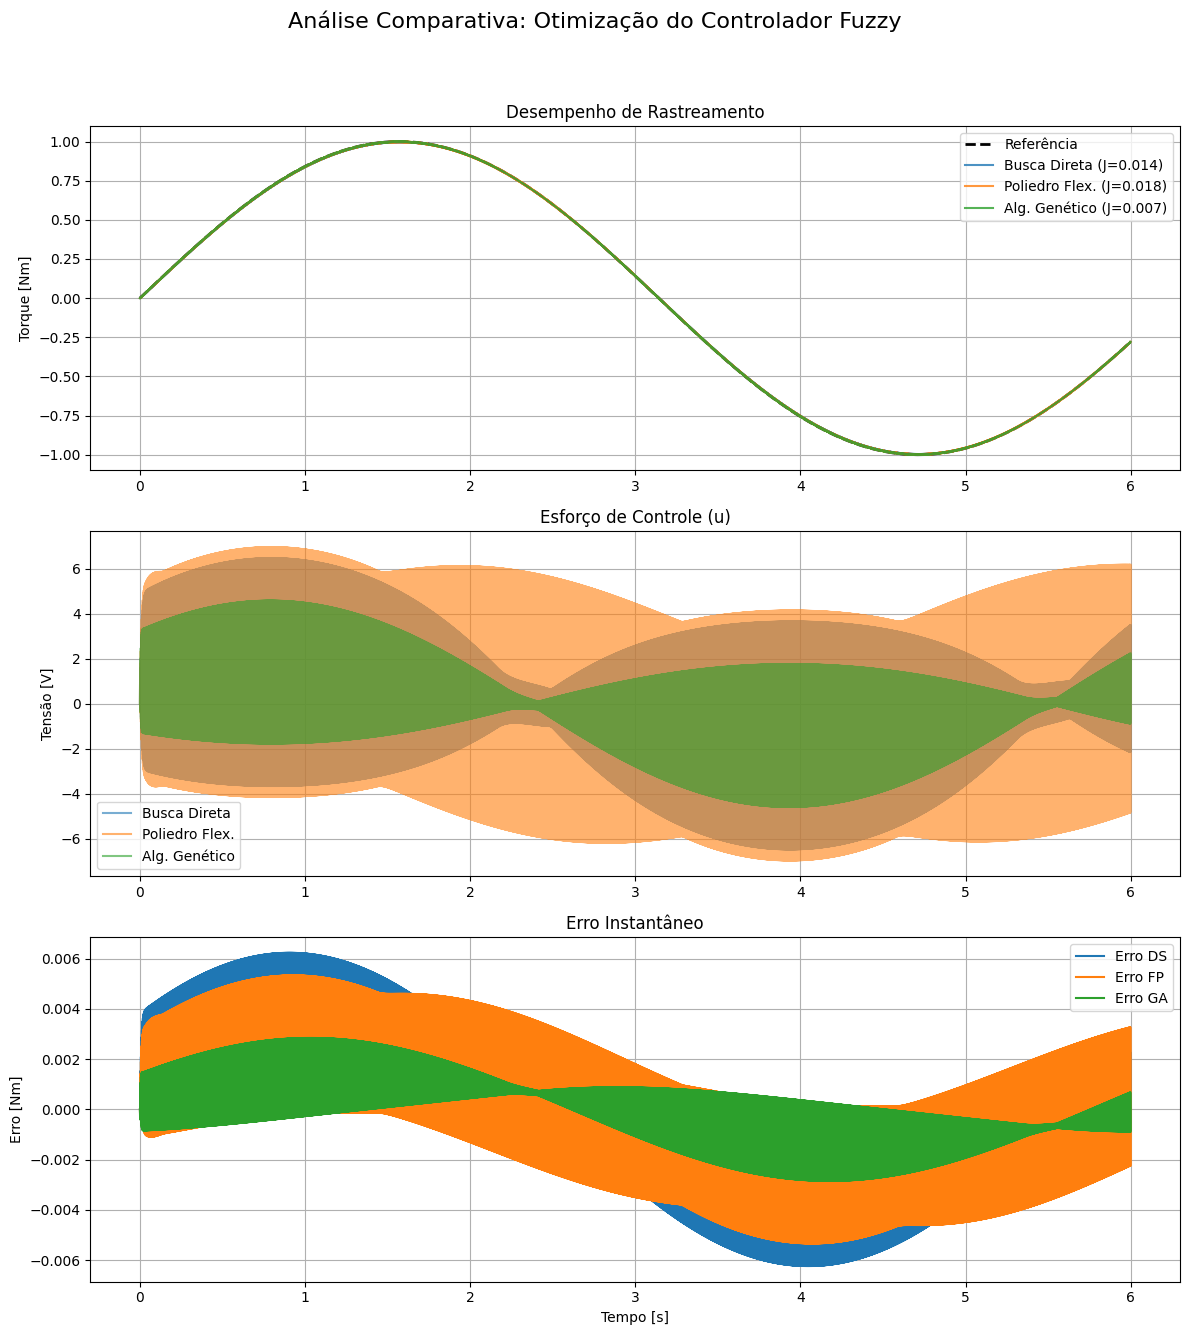

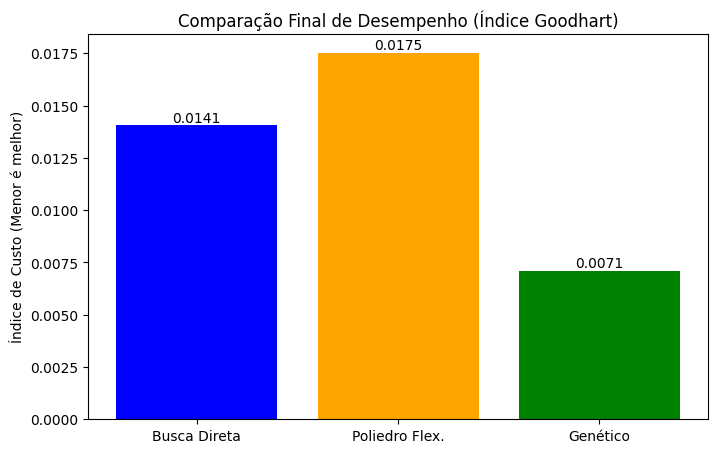

In [134]:
# Função de Simulação Fuzzy Takagi-Sugeno
def run_fuzzy_full_sim(params):
    controller = FuzzyTakagiSugeno(params)
    states_out = np.zeros(n - 1)
    u_out = np.zeros(n - 1)
    
    x = 0
    prev_error = 0
    u_limit = 100.0
    
    for i in range(n - 1):
        ref = torque_ref[i]
        error = ref - x
        
        if i == 0: derr = 0
        else: derr = (error - prev_error) / t_sim_step
            
        u = controller.calcular(error, derr)
        u = np.clip(u, -u_limit, u_limit)
        u_out[i] = u
        
        # Planta (Euler com passo pequeno é suficiente para visualização)
        dx = -a * k * x + k * u
        x = x + dx * t_sim_step
        
        states_out[i] = x
        prev_error = error
        
    return states_out, u_out

# Rodar simulações com os melhores parâmetros de cada método
y_ds, u_ds = run_fuzzy_full_sim(w_ds_fz)
y_fp, u_fp = run_fuzzy_full_sim(w_fp_fz)
y_ga, u_ga = run_fuzzy_full_sim(w_ga_fz)

# Cálculo dos Índices Finais
# Recalculando com a função metrics oficial para garantir precisão
idx_ds = calculate_indices(torque_ref[:-1], y_ds, time_vector[:-1], t_sim_step)
idx_fp = calculate_indices(torque_ref[:-1], y_fp, time_vector[:-1], t_sim_step)
idx_ga = calculate_indices(torque_ref[:-1], y_ga, time_vector[:-1], t_sim_step)

print("\n" + "="*65)
print(f"{'MÉTODO':<20} | {'MAE':<10} | {'MSE':<10} | {'ITAE':<10} | {'GOODHART (J)':<10}")
print("-" * 65)
print(f"{'Busca Direta':<20} | {idx_ds[0]:.4f}     | {idx_ds[1]:.4f}     | {idx_ds[2]:.4f}     | {idx_ds[3]:.4f}")
print(f"{'Poliedro Flexível':<20} | {idx_fp[0]:.4f}     | {idx_fp[1]:.4f}     | {idx_fp[2]:.4f}     | {idx_fp[3]:.4f}")
print(f"{'Algoritmo Genético':<20} | {idx_ga[0]:.4f}     | {idx_ga[1]:.4f}     | {idx_ga[2]:.4f}     | {idx_ga[3]:.4f}")
print("="*65 + "\n")

fig, axs = plt.subplots(3, 1, figsize=(12, 14))
plt.suptitle("Análise Comparativa: Otimização do Controlador Fuzzy", fontsize=16)

axs[0].plot(time_vector[:-1], torque_ref[:-1], "k--", linewidth=2, label="Referência")
axs[0].plot(time_vector[:-1], y_ds, label=f"Busca Direta (J={idx_ds[3]:.3f})", alpha=0.8)
axs[0].plot(time_vector[:-1], y_fp, label=f"Poliedro Flex. (J={idx_fp[3]:.3f})", alpha=0.8)
axs[0].plot(time_vector[:-1], y_ga, label=f"Alg. Genético (J={idx_ga[3]:.3f})", alpha=0.8)
axs[0].set_ylabel("Torque [Nm]")
axs[0].set_title("Desempenho de Rastreamento")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(time_vector[:-1], u_ds, label="Busca Direta", alpha=0.6)
axs[1].plot(time_vector[:-1], u_fp, label="Poliedro Flex.", alpha=0.6)
axs[1].plot(time_vector[:-1], u_ga, label="Alg. Genético", alpha=0.6)
axs[1].set_ylabel("Tensão [V]")
axs[1].set_title("Esforço de Controle (u)")
axs[1].legend()
axs[1].grid(True)

axs[2].plot(time_vector[:-1], torque_ref[:-1] - y_ds, label="Erro DS")
axs[2].plot(time_vector[:-1], torque_ref[:-1] - y_fp, label="Erro FP")
axs[2].plot(time_vector[:-1], torque_ref[:-1] - y_ga, label="Erro GA")
axs[2].set_ylabel("Erro [Nm]")
axs[2].set_xlabel("Tempo [s]")
axs[2].set_title("Erro Instantâneo")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

fig_bar, ax_bar = plt.subplots(figsize=(8, 5))
methods = ["Busca Direta", "Poliedro Flex.", "Genético"]
costs = [idx_ds[3], idx_fp[3], idx_ga[3]]
colors = ['blue', 'orange', 'green']

bars = ax_bar.bar(methods, costs, color=colors)
ax_bar.set_ylabel("Índice de Custo (Menor é melhor)")
ax_bar.set_title("Comparação Final de Desempenho (Índice Goodhart)")

for bar in bars:
    yval = bar.get_height()
    ax_bar.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.4f}", va='bottom', ha='center')

plt.show()

### Comparação PID vs Fuzzy
Agora rodamos a simulação de alta precisão (odeint adaptado) para comparar o PID melhor otimizado (genético) contra o Fuzzy (genético).

Melhores parâmetros:
PID (Algoritmo Genético): [175.12287934 222.20340192   0.        ]
Fuzzy T-S (Genetic Alg): [  0.23002625  43.82602169 127.41764358]
Fuzzy Mamdani: [ 0.125 13.5   51.5  ]
Rodando simulação final Mamdani (pode demorar um pouco)...


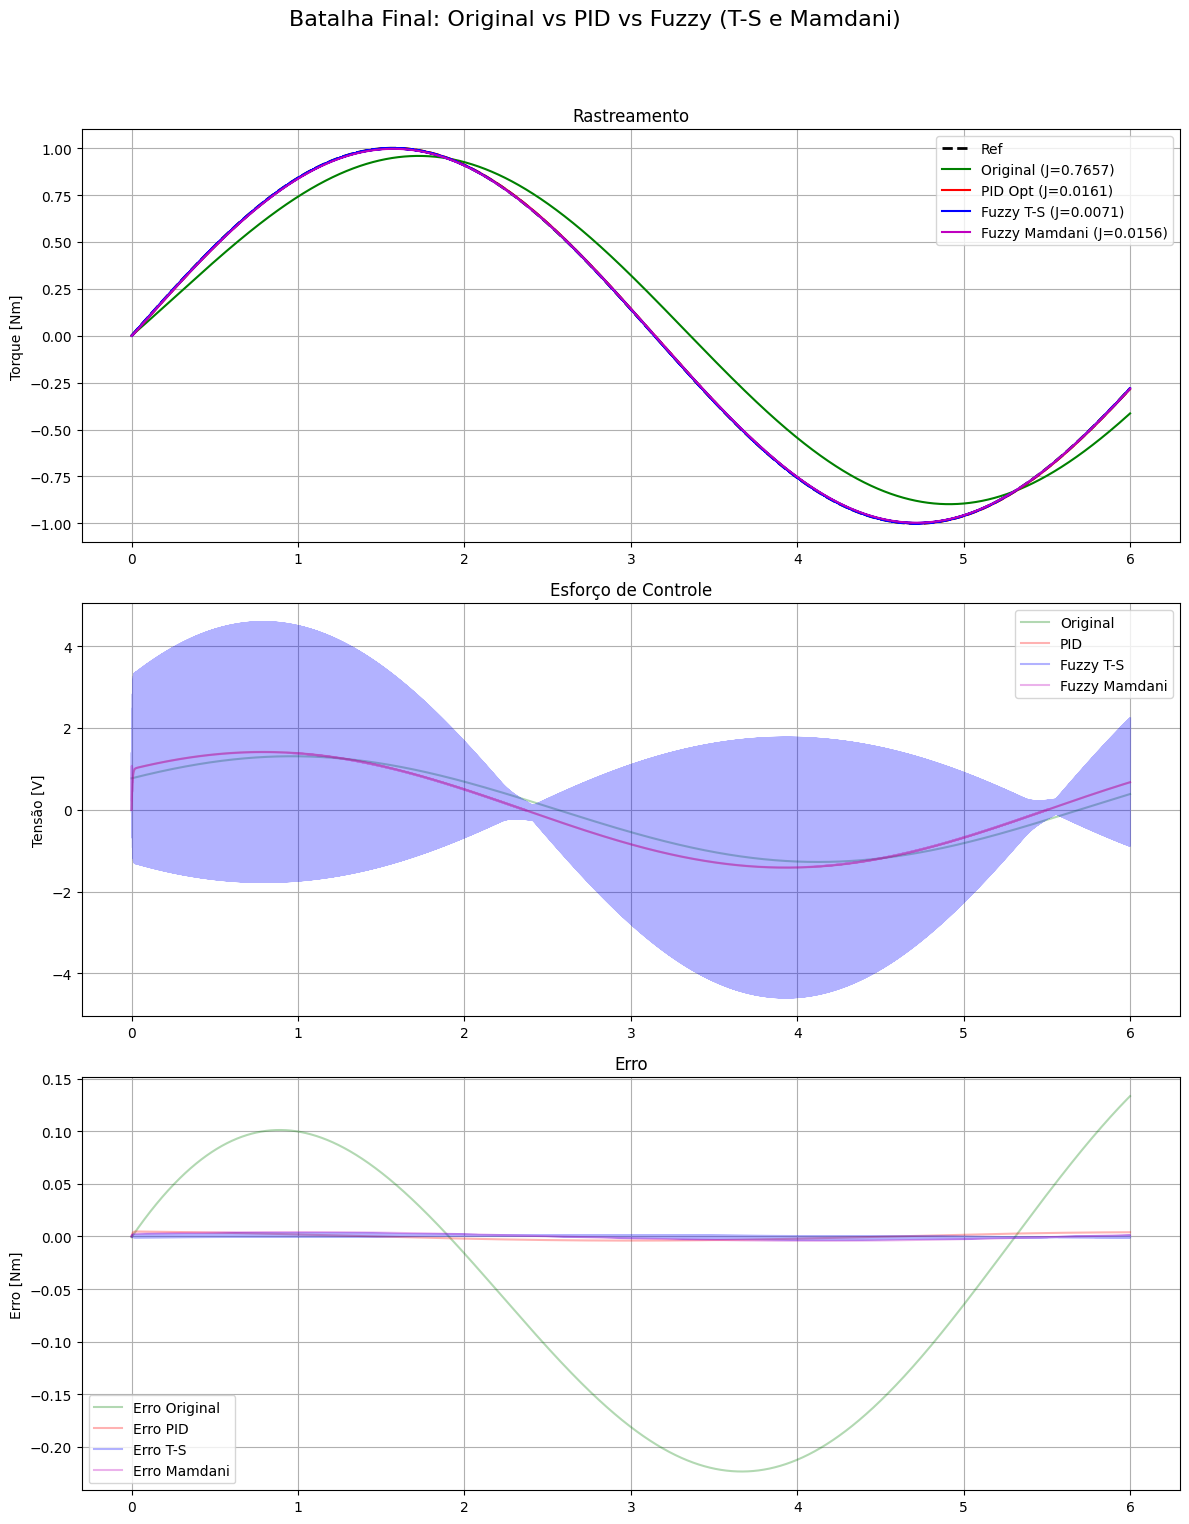

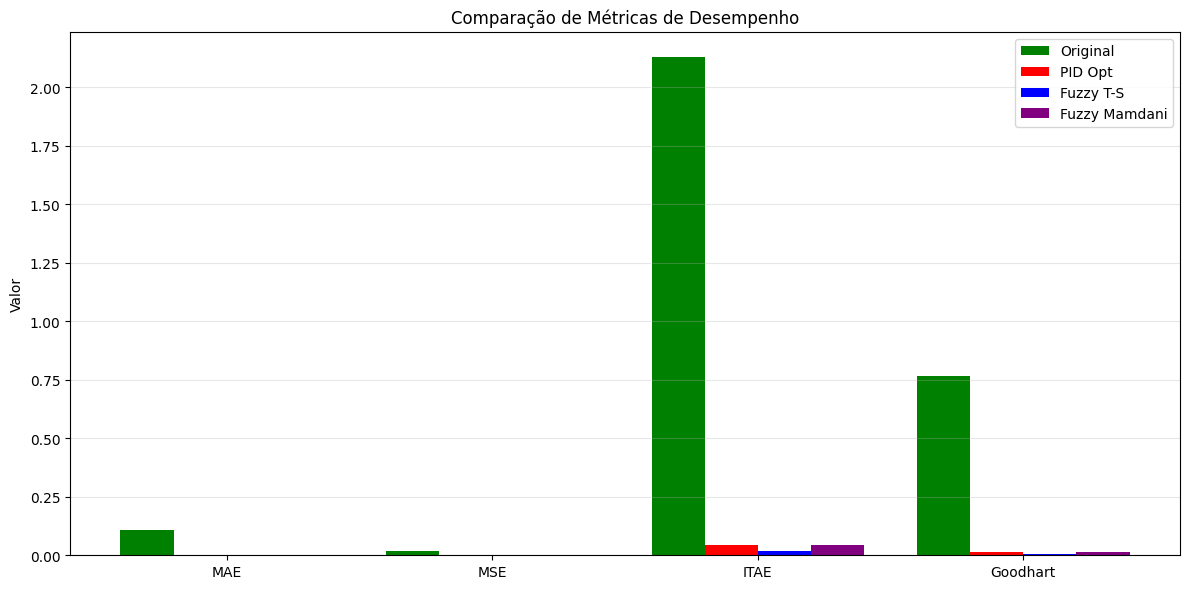


Métrica    | Original   | PID Opt    | Fuzzy T-S  | Fuzzy Mam 
------------------------------------------------------------
MAE        | 0.1086     | 0.0025     | 0.0012     | 0.0027    
MSE        | 0.0163     | 0.0000     | 0.0000     | 0.0000    
ITAE       | 2.1307     | 0.0448     | 0.0197     | 0.0433    
Goodhart   | 0.7657     | 0.0161     | 0.0071     | 0.0156    


In [ ]:
# Original vs PID vs Fuzzy T-S vs Fuzzy Mamdani

print(f"Melhores parâmetros:")
print(f"PID ({best_method_pid}): {w_pid_opt}")
print(f"Fuzzy T-S ({best_method_fz}): {w_fuzzy_opt}")
print(f"Fuzzy Mamdani: {w_mamdani_opt}")

# Função auxiliar para simulação Mamdani (Euler)
def run_fuzzy_mamdani_full_sim(params):
    controller = FuzzyMamdani(params)
    states_out = np.zeros(n - 1)
    u_out = np.zeros(n - 1)
    
    x = 0
    prev_error = 0
    u_limit = 100.0
    
    for i in range(n - 1):
        ref = torque_ref[i]
        error = ref - x
        
        if i == 0: derr = 0
        else: derr = (error - prev_error) / t_sim_step
            
        u = controller.calcular(error, derr)
        u = np.clip(u, -u_limit, u_limit)
        u_out[i] = u
        
        # Planta (Euler)
        dx = -a * k * x + k * u
        x = x + dx * t_sim_step
        
        states_out[i] = x
        prev_error = error
        
    return states_out, u_out

# Original (Baseline)
y_orig_final = np.zeros(n - 1)
u_orig_final = np.zeros(n - 1)
states0 = [0, 0]
for i in range(n - 1):
    # Recalculando u para plotagem
    u_val = original_control_law(states0[0], torque_ref[i], torquep_ref[i], k_c1, a, k, a_model_error, k_model_error)
    u_orig_final[i] = u_val
    
    # Simulação de um passo (ODEINT para o original, pois é contínuo/rápido)
    out = odeint(
        system_model_original,
        states0,
        [0.0, t_sim_step],
        args=(torque_ref[i], torquep_ref[i], k_c1, a, k, a_model_error, k_model_error),
    )
    states0 = out[-1, :]
    y_orig_final[i] = states0[0]

# PID Otimizado
y_pid_final, u_pid_final = run_full_sim(w_pid_opt)

# Fuzzy Takagi-Sugeno Otimizado
# Nota: run_fuzzy_full_sim usa FuzzyTakagiSugeno (definido na célula anterior)
y_fz_ts_final, u_fz_ts_final = run_fuzzy_full_sim(w_fuzzy_opt)

# Fuzzy Mamdani Otimizado
print("Rodando simulação final Mamdani (pode demorar um pouco)...")
y_fz_mam_final, u_fz_mam_final = run_fuzzy_mamdani_full_sim(w_mamdani_opt)

# Índices
idx_orig = calculate_indices(torque_ref[:-1], y_orig_final, time_vector[:-1], t_sim_step)
idx_pid = calculate_indices(torque_ref[:-1], y_pid_final[:, 0], time_vector[:-1], t_sim_step)
idx_fz_ts = calculate_indices(torque_ref[:-1], y_fz_ts_final, time_vector[:-1], t_sim_step)
idx_fz_mam = calculate_indices(torque_ref[:-1], y_fz_mam_final, time_vector[:-1], t_sim_step)

# Plotagem
fig5, axs = plt.subplots(3, 1, figsize=(12, 16))
plt.suptitle("Batalha Final: Original vs PID vs Fuzzy (T-S e Mamdani)", fontsize=16)

# Torque
axs[0].plot(time_vector[:-1], torque_ref[:-1], "k--", linewidth=2, label="Ref")
axs[0].plot(time_vector[:-1], y_orig_final, "g", label=f"Original (J={idx_orig[3]:.4f})")
axs[0].plot(time_vector[:-1], y_pid_final[:, 0], "r", label=f"PID Opt (J={idx_pid[3]:.4f})")
axs[0].plot(time_vector[:-1], y_fz_ts_final, "b", label=f"Fuzzy T-S (J={idx_fz_ts[3]:.4f})")
axs[0].plot(time_vector[:-1], y_fz_mam_final, "m", label=f"Fuzzy Mamdani (J={idx_fz_mam[3]:.4f})")
axs[0].set_ylabel("Torque [Nm]")
axs[0].set_title("Rastreamento")
axs[0].legend()
axs[0].grid(True)

# Tensão
axs[1].plot(time_vector[:-1], u_orig_final, "g", alpha=0.3, label="Original")
axs[1].plot(time_vector[:-1], u_pid_final, "r", alpha=0.3, label="PID")
axs[1].plot(time_vector[:-1], u_fz_ts_final, "b", alpha=0.3, label="Fuzzy T-S")
axs[1].plot(time_vector[:-1], u_fz_mam_final, "m", alpha=0.3, label="Fuzzy Mamdani")
axs[1].set_ylabel("Tensão [V]")
axs[1].set_title("Esforço de Controle")
axs[1].legend()
axs[1].grid(True)

# Erro
axs[2].plot(time_vector[:-1], torque_ref[:-1] - y_orig_final, "g", alpha=0.3, label="Erro Original")
axs[2].plot(time_vector[:-1], torque_ref[:-1] - y_pid_final[:, 0], "r", alpha=0.3, label="Erro PID")
axs[2].plot(time_vector[:-1], torque_ref[:-1] - y_fz_ts_final, "b", alpha=0.3, label="Erro T-S")
axs[2].plot(time_vector[:-1], torque_ref[:-1] - y_fz_mam_final, "m", alpha=0.3, label="Erro Mamdani")
axs[2].set_ylabel("Erro [Nm]")
axs[2].set_title("Erro")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Comparação Numérica e Gráfica
metrics_names = ['MAE', 'MSE', 'ITAE', 'Goodhart']
x = np.arange(len(metrics_names))
width = 0.2

fig_bar, ax_bar = plt.subplots(figsize=(12, 6))
rects1 = ax_bar.bar(x - 1.5*width, idx_orig, width, label='Original', color='green')
rects2 = ax_bar.bar(x - 0.5*width, idx_pid, width, label='PID Opt', color='red')
rects3 = ax_bar.bar(x + 0.5*width, idx_fz_ts, width, label='Fuzzy T-S', color='blue')
rects4 = ax_bar.bar(x + 1.5*width, idx_fz_mam, width, label='Fuzzy Mamdani', color='purple')

ax_bar.set_ylabel('Valor')
ax_bar.set_title('Comparação de Métricas de Desempenho')
ax_bar.set_xticks(x)
ax_bar.set_xticklabels(metrics_names)
ax_bar.legend()
ax_bar.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Tabela de Melhoria
print(f"\n{'Métrica':<10} | {'Original':<10} | {'PID Opt':<10} | {'Fuzzy T-S':<10} | {'Fuzzy Mam':<10}")
print("-" * 60)

for i, name in enumerate(metrics_names):
    print(f"{name:<10} | {idx_orig[i]:<10.4f} | {idx_pid[i]:<10.4f} | {idx_fz_ts[i]:<10.4f} | {idx_fz_mam[i]:<10.4f}")